# General application validation

In [1]:
from os import listdir
import json


def Id_dict(file):
    id_dict = {}
    for l in file:
        #        Make sure the line is long enough
        if len(l) >= 16:
            a = l.split('\t')
            #        Deal with the | in a[4]
            for i in a[4].split('|'):
                temp = [a[1].strip(), a[2].strip(), i.strip()]
                for j in range(0, 3):
                    if temp[j] == 'NA':
                        temp[j] = ''
                if a[0].strip() in id_dict:
                    id_dict[a[0].strip()].append(temp)
                else:
                    id_dict[a[0].strip()] = [temp]
    return id_dict


def Combined_chain_id_dict(id_dict):
    combined_chain_id_dict = {}
    for i in id_dict:
        temp = ['', '', '']
        for j in id_dict[i]:
            temp = [temp[0] + j[0], temp[1] + j[1], temp[2] + j[2]]
        combined_chain_id_dict[i] = temp
    return combined_chain_id_dict


def Here_iddict_combineddict(id_dict, combined_chain_id_dict, path):
    here_id_dict = {}
    here_combined_dict = {}
    names = listdir(path)
    for f in names:
        if len(f) == 8 and f[5:8] == 'pdb':
            if f[:4] in id_dict:
                here_id_dict[f[:4]] = id_dict[f[:4]]
            if f[:4] in combined_chain_id_dict:
                here_combined_dict[f[:4]] = combined_chain_id_dict[f[:4]]
    return here_id_dict, here_combined_dict


def output_combined_chain_id(path):
    with open('{}/summary.tsv'.format(path), 'r') as f:
        lines = f.readlines()
    id_dict = Id_dict(lines)
    combined_chain_id_dict = Combined_chain_id_dict(id_dict)
    here_iddict_combineddict = Here_iddict_combineddict(id_dict, combined_chain_id_dict, path)
    with open('./general application validation/here_conbined_chain_id.json', 'w') as f:
        json.dump(here_iddict_combineddict[1], f)
    with open('./general application validation/here_id_dict.json', 'w') as f:
        json.dump(here_iddict_combineddict[0], f)
    return here_iddict_combineddict


def witch_hunt(conbined_chain_id):
    # creat a container to contain the witches and GoodPeople
    witches = []
    GoodPeople = conbined_chain_id
    for i in conbined_chain_id:
        antibody_ids = conbined_chain_id[i][0] + conbined_chain_id[i][1]
        antigen_ids = conbined_chain_id[i][2]
        witch = False
        for i in antibody_ids:
            if i in antigen_ids:
                witch = True
                break
        if witch:
            witches.append(i)
            del GoodPeople[i]
    return witches, GoodPeople


def Chain_seq(file, combined_chain_id):
    # Combine all the ids together
    ids = combined_chain_id[0] + combined_chain_id[1] + combined_chain_id[2]
    # creat an empty dictionary, set a tracker to track whether an aa should be
    # added to the seq of a partitular chain
    seq = {}
    tracker = {}
    for i in ids:
        seq[i] = []
        tracker[i] = ''
    # load the sequences
    for line in file:
        if line[:6] == 'ATOM  ' and line[21] in ids:
            if tracker[line[21]] != line[22:27]:
                seq[line[21]].append(line[17:20])
                tracker[line[21]] = line[22:27]
    return seq


def Coordinates(file, combined_chain_id, l_range, h_range):
    # creat and empty dictionary to contain the results
    cdn = {}
    for i in combined_chain_id[0]:
        cdn['h1' + i], cdn['h2' + i], cdn['h3' + i] = [], [], []
    for i in combined_chain_id[1]:
        cdn['l1' + i], cdn['l2' + i], cdn['l3' + i] = [], [], []
    for i in combined_chain_id[2]:
        cdn[i] = []

    # creat a tracker dictionary, and a counter dictionary
    tracker = {}
    counter = {}
    ids = combined_chain_id[0] + combined_chain_id[1] + combined_chain_id[2]
    for i in ids:
        tracker[i] = ''
        counter[i] = -1

    # creat a dictionary to indicate the types of chains
    chain_type = {}
    for i in combined_chain_id[0]:
        chain_type[i] = 'H'
    for i in combined_chain_id[1]:
        chain_type[i] = 'L'
    for i in combined_chain_id[2]:
        chain_type[i] = 'A'

    # # set the range of CDRh and CDRl, all the numbers take the same counting system
    # # as python, with the firt one numbered 0.
    # l_range = [[23, 35], [45, 55], [88, 96]]
    # h_range = [[25, 35], [46, 64], [90, 109]]

    # extracting the coordinates
    for line in file:
        if line[:6] == 'ATOM  ' and line[21] in ids:
            # update the parameters
            if tracker[line[21]] != line[22:27]:
                counter[line[21]] += 1
                tracker[line[21]] = line[22:27]
            # extract all the parameters corresponding to line[21]
            c_type = chain_type[line[21]]
            count = counter[line[21]]
            # collect the coordinates according to c_type
            if c_type == 'H':
                # Tell the CDR type and load
                if count in range(h_range[0][0], h_range[0][1] + 1):
                    cdn['h1' + line[21]].append([float(line[30:38]), float(line[38:46]), float(line[46:54]),
                                                 count, line[17:20]])
                if count in range(h_range[1][0], h_range[1][1] + 1):
                    cdn['h2' + line[21]].append([float(line[30:38]), float(line[38:46]), float(line[46:54]),
                                                 count, line[17:20]])
                if count in range(h_range[2][0], h_range[2][1] + 1):
                    cdn['h3' + line[21]].append([float(line[30:38]), float(line[38:46]), float(line[46:54]),
                                                 count, line[17:20]])

            if c_type == 'L':
                # Tell the CDR type and load
                if count in range(l_range[0][0], l_range[0][1] + 1):
                    cdn['l1' + line[21]].append([float(line[30:38]), float(line[38:46]), float(line[46:54]),
                                                 count, line[17:20]])
                if count in range(l_range[1][0], l_range[1][1] + 1):
                    cdn['l2' + line[21]].append([float(line[30:38]), float(line[38:46]), float(line[46:54]),
                                                 count, line[17:20]])
                if count in range(l_range[2][0], l_range[2][1] + 1):
                    cdn['l3' + line[21]].append([float(line[30:38]), float(line[38:46]), float(line[46:54]),
                                                 count, line[17:20]])
            if c_type == 'A':
                cdn[line[21]].append([float(line[30:38]), float(line[38:46]), float(line[46:54]),
                                      count, line[17:20]])

    return cdn


def Get_contact(cdn, matched_ids, cutoff=4):
    # Creat an empty list to contain the temporary results
    contact_temp = []
    squared_cutoff = cutoff ** 2
    # sorting the keys into CDR and antigen groups
    # it is better to use the information of the matched ids
    # the grouped results should be stored in the form of[ [[h1H, h2H,h3h], [A]], ...]
    grouped = []
    for matched in matched_ids:
        if matched[2] != '':
            if matched[0] != '':
                grouped.append([['h1' + matched[0], 'h2' + matched[0], 'h3' + matched[0]], [matched[2]]])
            if matched[1] != '':
                grouped.append([['l1' + matched[1], 'l2' + matched[1], 'l3' + matched[1]], [matched[2]]])
    # calculate the contact according to the grouped
    for match in grouped:
        # calculate the distance and iterating through all possible combinations
        for i in match[0]:
            for j in match[1]:
                for atom1 in cdn[i]:
                    for atom2 in cdn[j]:
                        # We can accelerate this process by selecting the max abs first
                        diff = [atom1[0] - atom2[0], atom1[1] - atom2[1], atom1[2] - atom2[2]]
                        #                        if max(abs(diff)) < cutoff:
                        # is it faster to compare the square than the sequare root?
                        s = 0
                        for component in diff:
                            s += component ** 2
                            if s > squared_cutoff:  # this step can accelerate the calculation by a lot.
                                break
                        if s <= squared_cutoff:
                            contact_temp.append([i + j, atom1[3], atom2[3]])
                            #                            if np.dot(diff,diff) <= squared_cutoff:
                            #                                contact_temp.append([i+j, atom1[3], atom2[3]])
                            # Count the contact number
                            # Count method 1, use while to count
                            # \\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\#
                            #    contact = []
                            #    while contact_temp != []:
                            #        contact = contact_temp[0]
                            #        count = 0
                            #        while contact in contact_temp:
                            #            count += 1
                            #            contact_temp.remove(contact)
                            #        contact.append([contact[0], contact[1], contact[2], count])

    # Count method 2 Creat a dictionary to count\
    contact = []
    count_dict = {}
    for i in contact_temp:
        string = i[0] + '_' + str(i[1]) + '_' + str(i[2])
        if string in count_dict:
            count_dict[string] += 1
        else:
            count_dict[string] = 1
    # change the count_dict to contact
    contact = []
    for i in count_dict:
        element = i.split('_')
        element[1] = int(element[1])
        element[2] = int(element[2])
        element.append(count_dict[i])
        contact.append(element)

    return contact


def get_contact_from_data(path, l_range=((23, 35), (45, 55), (88, 96)), h_range=((25, 35), (46, 64), (90, 109))):
    print('Getting ID dict and combined dict from \'{}\'...'.format(path))
    here_iddict_combineddict = output_combined_chain_id(path)
    with open('./general application validation/here_conbined_chain_id.json', 'r') as f:
        here_conbined_chain_id = json.load(f)
    with open('./general application validation/here_id_dict.json', 'r') as f:
        here_id_dict = json.load(f)
    print('Hunting witches...')
    witches, GoodPeople = witch_hunt(here_conbined_chain_id)
    good_combined_ids = {}
    good_matched_ids = {}
    for i in GoodPeople:
        good_combined_ids[i] = here_conbined_chain_id[i]
        good_matched_ids[i] = here_id_dict[i]
    sequence = {}
    for i in good_combined_ids:
        with open(path + '/' + i + '.pdb', 'r') as file:
            sequence[i] = Chain_seq(file, good_combined_ids[i])
    print('Reading coordinates...')
    coordinates = {}
    for i in good_combined_ids:
        with open(path + '/' + i + '.pdb', 'r') as file:
            coordinates[i] = Coordinates(file, good_combined_ids[i], l_range, h_range)
    print('Calculating contact...')
    contact = {}
    length = len(coordinates)
    counter = 0
    for i in coordinates:
        counter += 1
        print('Calculating contact of \'{}.pdb\'... {}/{}'.format(i, counter, length))
        contact[i] = Get_contact(coordinates[i], good_matched_ids[i], cutoff=4)
    print('Done.')
    return contact

In [2]:
def count_contact(data_path, data_set_name='tmp'):
    print('Counting total contact...')
    total_contact_res = get_contact_from_data(data_path, ((0, 300), (300, 301), (301, 302)),
                                              ((0, 300), (300, 301), (301, 302)))
    # print(total_contact_res)
    with open('./general application validation/res/{}_total.json'.format(data_set_name), 'w') as f:
        json.dump(total_contact_res, f)
    total_contact_counter = 0
    for key in total_contact_res:
        for ele in total_contact_res[key]:
            total_contact_counter += ele[3]
    del total_contact_res
    print('total_contact_counter:', total_contact_counter)
    # with open('tmp.json','w') as f:
    #     json.dump(total_contact_res,f)

    print('Counting contact with limited range...')
    contact_res_with_limited_range = get_contact_from_data(data_path)
    # print(contact_res_with_limited_range)
    with open('./general application validation/res/{}_limited.json'.format(data_set_name), 'w') as f:
        json.dump(contact_res_with_limited_range, f)
    contact_with_limited_range_counter = 0
    for key in contact_res_with_limited_range:
        for ele in contact_res_with_limited_range[key]:
            contact_with_limited_range_counter += ele[3]
    del contact_res_with_limited_range
    print('contact_with_limited_range_counter:', contact_with_limited_range_counter)

    radio = contact_with_limited_range_counter / total_contact_counter
    print('radio:', radio)
    return radio

In [3]:
count_contact('./general application validation/data/homo sapiens','homo sapiens')

Counting total contact...
Getting ID dict and combined dict from './general application validation/data/homo sapiens'...
Hunting witches...
Reading coordinates...
Calculating contact...
Calculating contact of '4khx.pdb'... 1/674
Calculating contact of '4qhu.pdb'... 2/674
Calculating contact of '1tzg.pdb'... 3/674
Calculating contact of '4ut6.pdb'... 4/674
Calculating contact of '3wsq.pdb'... 5/674
Calculating contact of '4m1d.pdb'... 6/674
Calculating contact of '2fjh.pdb'... 7/674
Calculating contact of '3idg.pdb'... 8/674
Calculating contact of '4xcf.pdb'... 9/674
Calculating contact of '5tfw.pdb'... 10/674
Calculating contact of '4m8q.pdb'... 11/674
Calculating contact of '4hha.pdb'... 12/674
Calculating contact of '2b4c.pdb'... 13/674
Calculating contact of '3egs.pdb'... 14/674
Calculating contact of '5wnb.pdb'... 15/674
Calculating contact of '4jkp.pdb'... 16/674
Calculating contact of '2ny6.pdb'... 17/674
Calculating contact of '3wd5.pdb'... 18/674
Calculating contact of '5vig.pd

Calculating contact of '5u3k.pdb'... 182/674
Calculating contact of '2fx8.pdb'... 183/674
Calculating contact of '5hhv.pdb'... 184/674
Calculating contact of '5u3d.pdb'... 185/674
Calculating contact of '1i9r.pdb'... 186/674
Calculating contact of '3d85.pdb'... 187/674
Calculating contact of '5ush.pdb'... 188/674
Calculating contact of '3mlr.pdb'... 189/674
Calculating contact of '6b5l.pdb'... 190/674
Calculating contact of '3b2v.pdb'... 191/674
Calculating contact of '3gbn.pdb'... 192/674
Calculating contact of '5bjz.pdb'... 193/674
Calculating contact of '6d11.pdb'... 194/674
Calculating contact of '3se9.pdb'... 195/674
Calculating contact of '4tsa.pdb'... 196/674
Calculating contact of '2j6e.pdb'... 197/674
Calculating contact of '6b0g.pdb'... 198/674
Calculating contact of '5ggt.pdb'... 199/674
Calculating contact of '5usi.pdb'... 200/674
Calculating contact of '3nps.pdb'... 201/674
Calculating contact of '5u6a.pdb'... 202/674
Calculating contact of '3c2a.pdb'... 203/674
Calculatin

Calculating contact of '4v1d.pdb'... 365/674
Calculating contact of '5d1x.pdb'... 366/674
Calculating contact of '5te7.pdb'... 367/674
Calculating contact of '5dhy.pdb'... 368/674
Calculating contact of '5mvz.pdb'... 369/674
Calculating contact of '4pgj.pdb'... 370/674
Calculating contact of '2h3n.pdb'... 371/674
Calculating contact of '3fku.pdb'... 372/674
Calculating contact of '6bp2.pdb'... 373/674
Calculating contact of '5w08.pdb'... 374/674
Calculating contact of '5xez.pdb'... 375/674
Calculating contact of '5ggr.pdb'... 376/674
Calculating contact of '4lmq.pdb'... 377/674
Calculating contact of '4om0.pdb'... 378/674
Calculating contact of '6bqb.pdb'... 379/674
Calculating contact of '6b0n.pdb'... 380/674
Calculating contact of '2wuc.pdb'... 381/674
Calculating contact of '4rx4.pdb'... 382/674
Calculating contact of '2nxz.pdb'... 383/674
Calculating contact of '3sdy.pdb'... 384/674
Calculating contact of '5x8m.pdb'... 385/674
Calculating contact of '2eiz.pdb'... 386/674
Calculatin

Calculating contact of '4g6a.pdb'... 548/674
Calculating contact of '3drq.pdb'... 549/674
Calculating contact of '1yyl.pdb'... 550/674
Calculating contact of '3fn0.pdb'... 551/674
Calculating contact of '4wuu.pdb'... 552/674
Calculating contact of '5fv2.pdb'... 553/674
Calculating contact of '4g6m.pdb'... 554/674
Calculating contact of '4nzr.pdb'... 555/674
Calculating contact of '3h3p.pdb'... 556/674
Calculating contact of '1ikf.pdb'... 557/674
Calculating contact of '4lkx.pdb'... 558/674
Calculating contact of '6b5m.pdb'... 559/674
Calculating contact of '4al8.pdb'... 560/674
Calculating contact of '1mcd.pdb'... 561/674
Calculating contact of '6c9u.pdb'... 562/674
Calculating contact of '5dur.pdb'... 563/674
Calculating contact of '4dqo.pdb'... 564/674
Calculating contact of '5m2j.pdb'... 565/674
Calculating contact of '2ghw.pdb'... 566/674
Calculating contact of '5bk0.pdb'... 567/674
Calculating contact of '4yhp.pdb'... 568/674
Calculating contact of '2oqj.pdb'... 569/674
Calculatin

Calculating contact of '5hi4.pdb'... 53/674
Calculating contact of '6b5o.pdb'... 54/674
Calculating contact of '1u8h.pdb'... 55/674
Calculating contact of '6azm.pdb'... 56/674
Calculating contact of '4jdt.pdb'... 57/674
Calculating contact of '3go1.pdb'... 58/674
Calculating contact of '3hi1.pdb'... 59/674
Calculating contact of '4p59.pdb'... 60/674
Calculating contact of '3kr3.pdb'... 61/674
Calculating contact of '5mev.pdb'... 62/674
Calculating contact of '5wux.pdb'... 63/674
Calculating contact of '3u7y.pdb'... 64/674
Calculating contact of '3idy.pdb'... 65/674
Calculating contact of '5t3x.pdb'... 66/674
Calculating contact of '5w6d.pdb'... 67/674
Calculating contact of '4odx.pdb'... 68/674
Calculating contact of '5wn9.pdb'... 69/674
Calculating contact of '4ydv.pdb'... 70/674
Calculating contact of '5kw9.pdb'... 71/674
Calculating contact of '5bo1.pdb'... 72/674
Calculating contact of '4s1r.pdb'... 73/674
Calculating contact of '1nl0.pdb'... 74/674
Calculating contact of '5bk2.pdb

Calculating contact of '2ny7.pdb'... 238/674
Calculating contact of '2ny5.pdb'... 239/674
Calculating contact of '1h0d.pdb'... 240/674
Calculating contact of '1mcc.pdb'... 241/674
Calculating contact of '6fxn.pdb'... 242/674
Calculating contact of '3eoa.pdb'... 243/674
Calculating contact of '4jzo.pdb'... 244/674
Calculating contact of '4dag.pdb'... 245/674
Calculating contact of '4nzt.pdb'... 246/674
Calculating contact of '4xmk.pdb'... 247/674
Calculating contact of '4i3r.pdb'... 248/674
Calculating contact of '4xwg.pdb'... 249/674
Calculating contact of '4olu.pdb'... 250/674
Calculating contact of '5t3z.pdb'... 251/674
Calculating contact of '5zv3.pdb'... 252/674
Calculating contact of '4xx1.pdb'... 253/674
Calculating contact of '5u3o.pdb'... 254/674
Calculating contact of '4dvr.pdb'... 255/674
Calculating contact of '4g7v.pdb'... 256/674
Calculating contact of '4d9q.pdb'... 257/674
Calculating contact of '5kzp.pdb'... 258/674
Calculating contact of '2yss.pdb'... 259/674
Calculatin

Calculating contact of '2qqk.pdb'... 422/674
Calculating contact of '3x3f.pdb'... 423/674
Calculating contact of '1u8k.pdb'... 424/674
Calculating contact of '4np4.pdb'... 425/674
Calculating contact of '5grj.pdb'... 426/674
Calculating contact of '6b5r.pdb'... 427/674
Calculating contact of '5ies.pdb'... 428/674
Calculating contact of '3lzf.pdb'... 429/674
Calculating contact of '2f5b.pdb'... 430/674
Calculating contact of '4jzn.pdb'... 431/674
Calculating contact of '5u5m.pdb'... 432/674
Calculating contact of '4dgv.pdb'... 433/674
Calculating contact of '5u7o.pdb'... 434/674
Calculating contact of '4rrp.pdb'... 435/674
Calculating contact of '4ngh.pdb'... 436/674
Calculating contact of '5lbs.pdb'... 437/674
Calculating contact of '5utz.pdb'... 438/674
Calculating contact of '1g9n.pdb'... 439/674
Calculating contact of '4d9r.pdb'... 440/674
Calculating contact of '5uea.pdb'... 441/674
Calculating contact of '3qnz.pdb'... 442/674
Calculating contact of '5vag.pdb'... 443/674
Calculatin

Calculating contact of '5n09.pdb'... 606/674
Calculating contact of '5iq7.pdb'... 607/674
Calculating contact of '1rzk.pdb'... 608/674
Calculating contact of '3ghb.pdb'... 609/674
Calculating contact of '3l5y.pdb'... 610/674
Calculating contact of '4ye4.pdb'... 611/674
Calculating contact of '5cd5.pdb'... 612/674
Calculating contact of '3nfp.pdb'... 613/674
Calculating contact of '4jm2.pdb'... 614/674
Calculating contact of '2fx7.pdb'... 615/674
Calculating contact of '4i3s.pdb'... 616/674
Calculating contact of '4om1.pdb'... 617/674
Calculating contact of '4ps4.pdb'... 618/674
Calculating contact of '4yjz.pdb'... 619/674
Calculating contact of '1tjh.pdb'... 620/674
Calculating contact of '3lh2.pdb'... 621/674
Calculating contact of '4irz.pdb'... 622/674
Calculating contact of '2qad.pdb'... 623/674
Calculating contact of '5yoy.pdb'... 624/674
Calculating contact of '4zff.pdb'... 625/674
Calculating contact of '5dum.pdb'... 626/674
Calculating contact of '5f9o.pdb'... 627/674
Calculatin

0.8679851460079896

In [4]:
count_contact('./general application validation/data/lama glama','lama glama')

Counting total contact...
Getting ID dict and combined dict from './general application validation/data/lama glama'...
Hunting witches...
Reading coordinates...
Calculating contact...
Calculating contact of '4z9k.pdb'... 1/126
Calculating contact of '5vaq.pdb'... 2/126
Calculating contact of '4pir.pdb'... 3/126
Calculating contact of '4w6w.pdb'... 4/126
Calculating contact of '3k80.pdb'... 5/126
Calculating contact of '4nc2.pdb'... 6/126
Calculating contact of '4n1h.pdb'... 7/126
Calculating contact of '3zks.pdb'... 8/126
Calculating contact of '4cdg.pdb'... 9/126
Calculating contact of '3rjq.pdb'... 10/126
Calculating contact of '5vak.pdb'... 11/126
Calculating contact of '3stb.pdb'... 12/126
Calculating contact of '4gft.pdb'... 13/126
Calculating contact of '4bel.pdb'... 14/126
Calculating contact of '4nc1.pdb'... 15/126
Calculating contact of '3sn6.pdb'... 16/126
Calculating contact of '4lde.pdb'... 17/126
Calculating contact of '4s10.pdb'... 18/126
Calculating contact of '5f93.pdb'

Calculating contact of '6fuz.pdb'... 52/126
Calculating contact of '4eig.pdb'... 53/126
Calculating contact of '5f1k.pdb'... 54/126
Calculating contact of '5ja8.pdb'... 55/126
Calculating contact of '5sv3.pdb'... 56/126
Calculating contact of '4bfb.pdb'... 57/126
Calculating contact of '5c1m.pdb'... 58/126
Calculating contact of '5f9d.pdb'... 59/126
Calculating contact of '5m95.pdb'... 60/126
Calculating contact of '5jqh.pdb'... 61/126
Calculating contact of '5f8q.pdb'... 62/126
Calculating contact of '4i13.pdb'... 63/126
Calculating contact of '5mp2.pdb'... 64/126
Calculating contact of '4wgw.pdb'... 65/126
Calculating contact of '4c59.pdb'... 66/126
Calculating contact of '4w2o.pdb'... 67/126
Calculating contact of '5f21.pdb'... 68/126
Calculating contact of '4i1n.pdb'... 69/126
Calculating contact of '5g5x.pdb'... 70/126
Calculating contact of '4nbx.pdb'... 71/126
Calculating contact of '4c58.pdb'... 72/126
Calculating contact of '3cfi.pdb'... 73/126
Calculating contact of '5j57.pdb

0.848843629225201

In [10]:
import matplotlib.pyplot as plt
import numpy as np

In [15]:
def histogram(contact_data):

    data_h, data_l = [], []
    h_range, l_range = 0, 0
    for key in contact_data:
        for ele in contact_data[key]:
            if ele[0][0] == 'h':
                if ele[1] > h_range:
                    h_range = ele[1]
                for i in range(ele[3]):
                    data_h.append(ele[1])
            if ele[0][0] == 'l':
                if ele[1] > l_range:
                    l_range = ele[1]
                for i in range(ele[3]):
                    data_l.append(ele[1])
    # max_data_h = max()
    print(h_range)
    print(l_range)
    max_data_l = max(data_l)
    print('plotting...')
    # plt.subplots_adjust(hspace=0.3)
#     plt.subplot(2, 1, 1)
    plt.title('heavy chain')
    plt.xlabel('position')
    plt.ylabel('frequency')
    plt.xticks(np.arange(0, h_range+1, int((h_range+1)/15)))
    # plt.yticks(list(range(0, max_data_h, int(max_data_h/25))))
    plt.hist(data_h, bins=h_range+1,normed=True)
    plt.show()
#     plt.subplot(2, 1, 2)
    plt.title('light chain')
    plt.xlabel('position')
    plt.ylabel('frequency')
    plt.xticks(np.arange(0, l_range+1, int((l_range+1)/15)))
    # plt.yticks(list(range(0, max_data_l, int(max_data_l/25))))

    plt.hist(data_l, bins=l_range+1,normed=True)
    plt.show()

## homo sapiens

230
223
plotting...


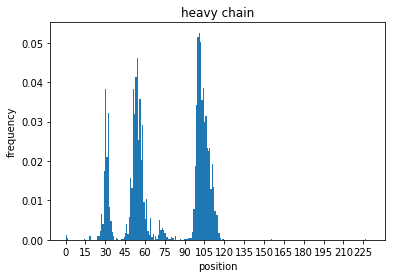

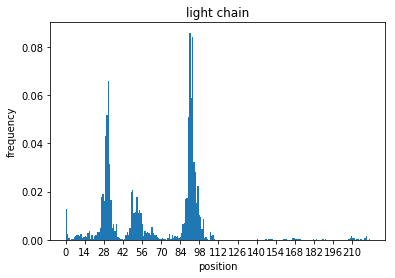

In [16]:
path = './general application validation/res/homo sapiens/homo sapiens_total.json'
with open(path, 'r') as f:
    contact_data = json.load(f)
histogram(contact_data)

## lama glama

120
95
plotting...


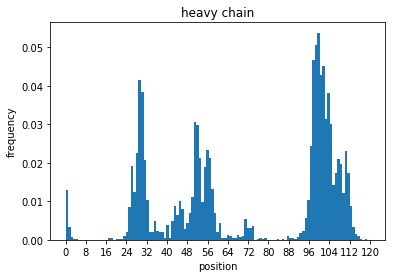

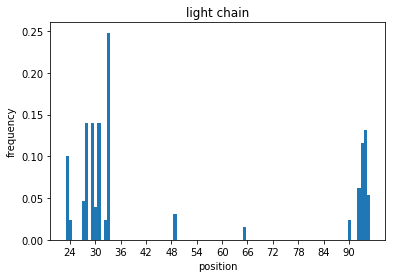

In [17]:
path = './general application validation/res/lama glama/lama glama_total.json'
with open(path, 'r') as f:
    contact_data = json.load(f)
histogram(contact_data)